In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import scipy.stats
import typing
%matplotlib inline

In [2]:
class Image():
    color_scheme = None
    cv_img = None
    std_map = None
    
    def __init__(self):
        pass
    
    @staticmethod
    def from_file(file: str) -> "Image":
        """
        Load img to BGR format
        """
        self = Image()
        img = cv2.imread(file, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError("'{}' does not seem to be a valid image (Code: 39482039)".format(file))
            
        self.data = img
        self.color_scheme = "bgr"
        return self
    
    def to_hsv(self) -> "Image":
        """
        Converts img to HSV format
        """
        if self.color_scheme == "bgr":
            self.data = cv2.cvtColor(self.data, cv2.COLOR_BGR2HSV)
        elif self.color_scheme == "hsv":
            pass
        elif self.color_scheme == "rgb":
            self.data = cv2.cvtColor(self.data, cv2.COLOR_RGB2HSV)
        else:
            raise Exception("I don't support format {} (Code: 234232323443)".format(self.color_scheme))
            
        self.color_scheme = "hsv"
        
    def to_bgr(self) -> "Image":
        """
        Converts to BGR
        """
        if self.color_scheme == "hsv":
            self.data = cv2.cvtColor(self.data, cv2.COLOR_HSV2BGR)
        elif self.color_scheme == "bgr":
            pass
        elif self.color_scheme == "rbg":
            self.data = cv2.cvtColor(self.data, cv2.COLOR_RGB2BGR)
        else:
            raise Exception("I don't support format {} (Code: 456456455)".format(self.color_scheme))

        self.color_scheme = "bgr"

        return self

    def to_bgr(self) -> "Image":
        """
        Converts to BGR
        """
        if self.color_scheme == "hsv":
            self.data = cv2.cvtColor(self.data, cv2.COLOR_HSV2BGR)
        elif self.color_scheme == "bgr":
            pass
        elif self.color_scheme == "rbg":
            self.data = cv2.cvtColor(self.data, cv2.COLOR_RGB2BGR)
        else:
            raise Exception("I don't support format {} (Code: 345345564554)".format(self.color_scheme))

        self.color_scheme = "bgr"

        return self
    
    def to_rgb(self) -> "Image":
        """
        Converts to RGB
        """
        if self.color_scheme == "hsv":
            self.data = cv2.cvtColor(self.data, cv2.COLOR_HSV2RGB)
        elif self.color_scheme == "rgb":
            pass
        elif self.color_scheme == "bgr":
            self.data = cv2.cvtColor(self.data, cv2.COLOR_BGR2RGB)
        else:
            raise Exception("I don't support format {} (Code: 2342323423456)".format(self.color_scheme))

        self.color_scheme = "rgb"

        return self
    
    def draw_to_fig(self, fig:plt.Figure=None):
        """
        Draws img in current mode channel by channel on fig
        figure has to have at least four axes
        """
        dimensions = [0,1,2,':']

        if fig == None:
            fig, ax = plt.subplots(nrows=len(dimensions), figsize=(24,24))
        else:
            plt.scf(fig)
            ax = fig.get_axes()
        
        if len(ax) < len(dimensions):
            raise ValueError("Your figure needs to have at least {} axes (Code: 3924823)".format(len(dimensions)))
            
        for i, dimension in enumerate(dimensions):
            plt.sca(ax[i])
            if dimension != ':':
                plt.imshow(cv2.bilateralFilter(self.data[:, :, dimension], 5, 10, 10))
            else:
                plt.imshow(self.data)
    
    def calculate_stdev_map(self, size:int=10, axis:chr=':', 
                            iterations=1, 
                            blur:bool=True, 
                            normalize_channels:bool=True, 
                            slim_lines:bool=True) -> "Image":
        """
        and calculate a map of stdev of kernel size
        over V-channel
        """
        
       
        for i in range(iterations):
            if i > 0:
                channel = self.std_map
                axis = None
            else:
                if axis == ':':
                    channel = np.asarray(self.data[:, :, :], dtype=np.float32)
                   
                    if normalize_channels:
                        for i in range(len(channel[0, 0])):
                            channel[:, :, i] /= (np.max(channel[:,:,i]) + 1e-7)
                    if blur:
                        for i in range(len(channel[0, 0])):
                            # channel[:, :, i] = cv2.filter2D(src=channel[:, :, i], 
                            #                                ddepth=-1, 
                            #                                kernel=np.ones(shape=(size * 2, size * 2)) / pow(size*2, 2) )
                            
                            channel[:, :, i] = cv2.bilateralFilter(channel[:, :, i], 5, size, size)

                else:
                    channel = np.asarray(self.data[:, :, int(axis)], dtype=np.float32)
                    if normalize_channels:
                        channel /= (np.max(channel) + 1e-7)
                    if blur:
                        #channel = cv2.filter2D(src=channel, ddepth=-1, kernel=np.ones(shape=(size * 2, size * 2)) / pow(size*2, 2))
                        channel = cv2.bilateralFilter(channel, 5, size, size)
                   
            # This is some mathematical shit, idk why that works :)
            # read https://stackoverflow.com/a/18422519/5592561
            c1 = scipy.ndimage.uniform_filter(channel, size=size, mode="reflect")
            c2 = scipy.ndimage.uniform_filter(channel * channel, size=size, mode='reflect')
            data_1 = (c2 - c1 * c1)
            data_1 += np.abs(np.min(data_1))
            # data_1[data_1 <= 0.] = 1e-10
            data_1 **= 0.5

            if axis == ':':
                data_1 = np.sum(data_1, axis=-1) / data_1.shape[-1]

            blur = False
            self.std_map = data_1

        if slim_lines:
            self.std_map = scipy.ndimage.filters.minimum_filter(self.std_map, size= size - 1, mode="reflect")
            
            
        return self
    
    def get_square_pixels(self) -> int:
        return len(img.data) * len(img.data[0])


In [3]:
img = Image.from_file(file="band2.jpg")

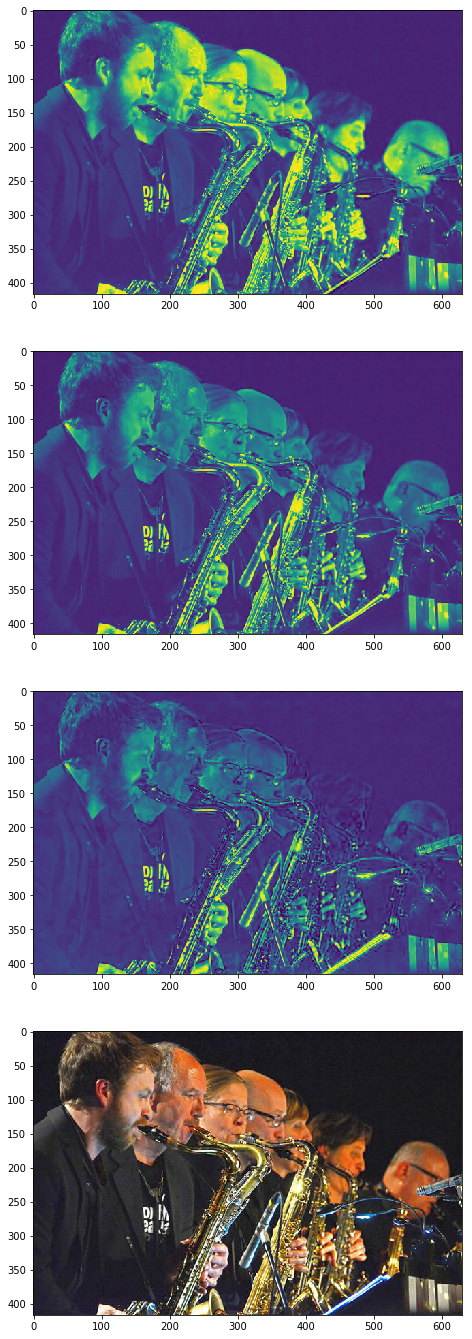

In [4]:
img.to_rgb()
img.draw_to_fig()

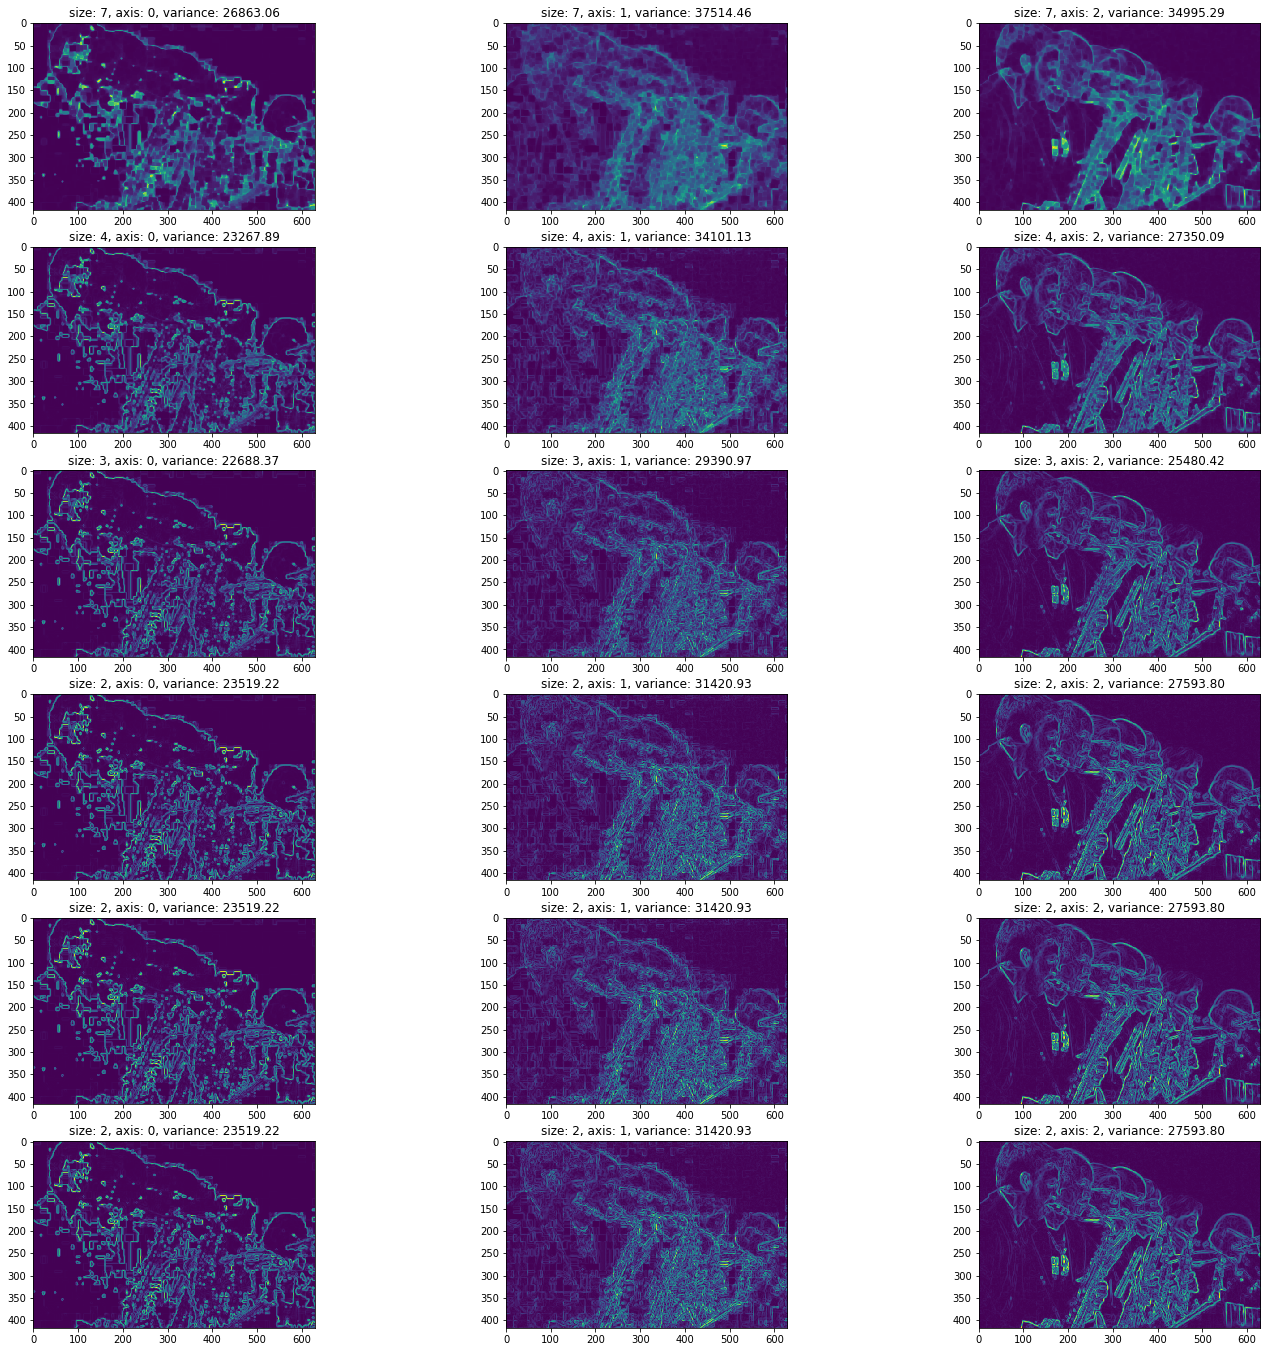

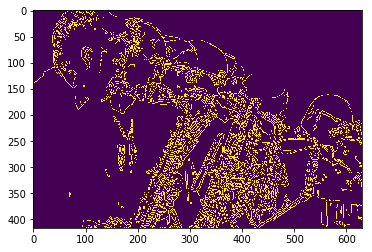

In [8]:
sizes = [int(np.sqrt(img.get_square_pixels())) // x 
         for x in range(70, 250, 35) 
         if int(np.sqrt(img.get_square_pixels())) // x >= 2]
axes = ['0','1','2']
fig, ax = plt.subplots(nrows=len(sizes), ncols=len(axes), figsize=(24,24))
ax = np.ndarray.flatten(ax)
#ax = np.ndarray.flatten(ax)
img.to_hsv()
i = 0
for i1, size in enumerate(sizes):    
    for i2, axis in enumerate(axes):
        img.calculate_stdev_map(size=size, 
                                axis=axis, 
                                iterations=1, 
                                blur=True,
                                slim_lines=True)
        
        plt.sca(ax[i1 * len(axes) + i2])
        std_map = img.std_map

        # remove noise
        #std_map[(std_map[:,:] < np.percentile(std_map, 50.))] = 0.
        #print(np.min(std_map), np.max(std_map))
        #std_map[(std_map[:,:] > np.percentile(std_map, 90.))] = 1.
        #std_map[(std_map[:,:] != 1.)] = 0.

        plt.imshow(std_map)
        plt.gca().set_title("size: {0}, axis: {1}, variance: {2:.2f}".format(size, axis, np.sum(std_map / np.max(std_map))))
        i+=1
        
        
# as comparison we Canny result on same picture
fix, ax = plt.subplots(nrows=1, ncols=1)
img.to_bgr()
plt.imshow(cv2.Canny(cv2.cvtColor(img.data, cv2.COLOR_BGR2GRAY), 100, 200))

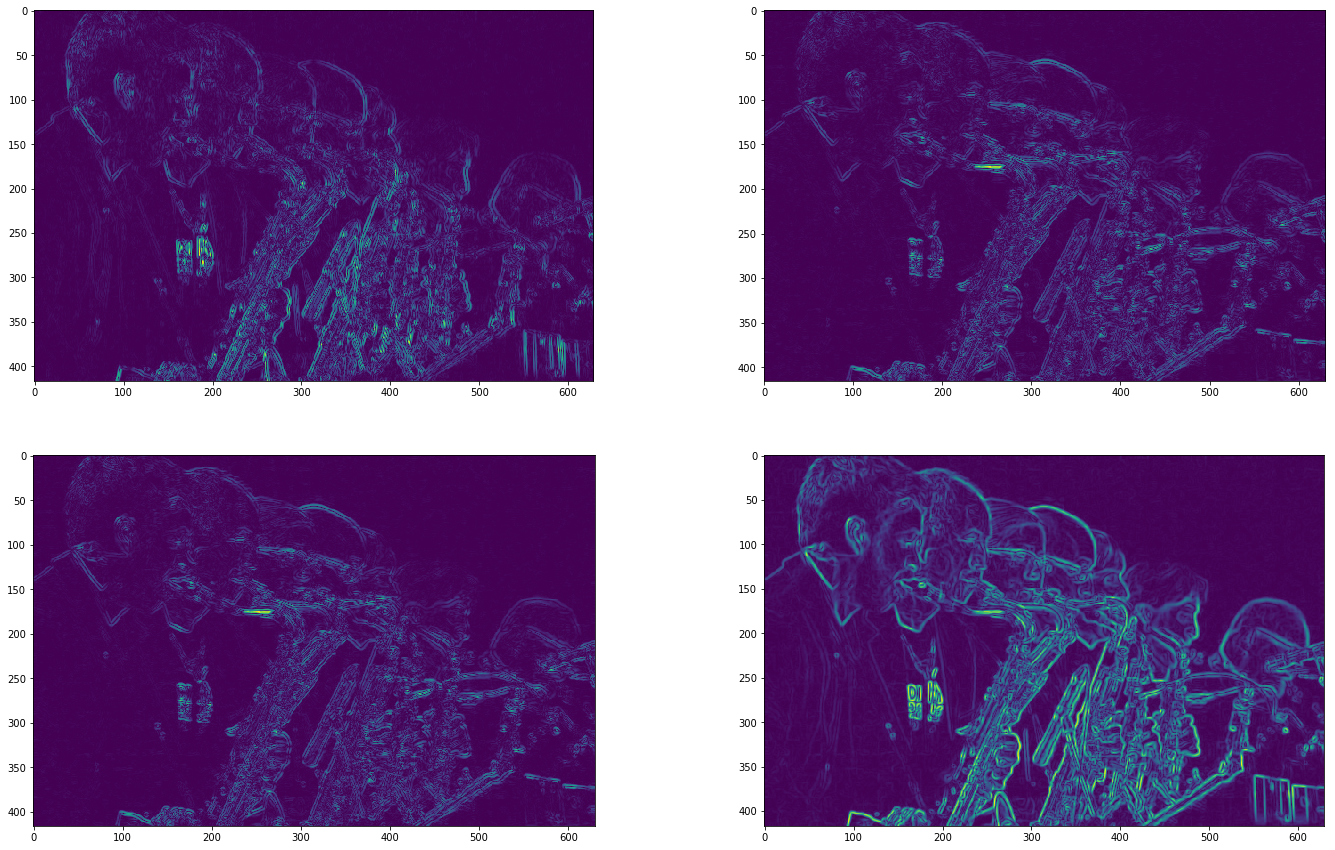

In [26]:
fix, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 15))
img.to_hsv()
img.calculate_stdev_map(axis=2, size=int(np.sqrt(img.get_square_pixels())) // 200 )
plt.sca(ax[0][0])
plt.imshow(abs(np.diff(img.std_map, n=1, axis=1)))
plt.sca(ax[0][1])
plt.imshow(abs(np.diff(img.std_map, n=1, axis=0)))
plt.sca(ax[1][0])
plt.imshow(abs(np.diff(img.std_map, n=1, axis=0)) + abs(np.diff(img.std_map, n=1, axis=0)))
plt.sca(ax[1][1])
plt.imshow(img.std_map)